In [44]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from torch.utils.data import Dataset, DataLoader
import torch
from typing import List, Tuple, Optional
import pytorch_lightning as pl
from pathlib import Path
import numpy as np

class Noise2NoiseDataset(Dataset):
    def __init__(
        self,
        image_paths: List[str],
        patch_size: int = 128,
        noise_std: float = 0.15,
        is_validation: bool = False
    ):

        self.image_paths = image_paths
        self.noise_std = noise_std
        self.is_validation = is_validation
        self.patch_size = patch_size
        
        if is_validation:
            self.transform = A.Compose([
                A.CenterCrop(height=patch_size, width=patch_size),
                A.ToFloat(max_value=255.0),
                ToTensorV2(),
            ])
        else:
            self.transform = A.Compose([
                # A.RandomCrop(height=patch_size, width=patch_size),
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                A.RandomRotate90(p=0.5),
                A.ToFloat(max_value=255.0),
                ToTensorV2(),
            ])

    def __len__(self):
        return len(self.image_paths)

    def add_noise(self, clean_tensor: torch.Tensor) -> torch.Tensor:
        noise = torch.randn_like(clean_tensor) * self.noise_std
        noisy_tensor = torch.clamp(clean_tensor + noise, 0.0, 1.0)
        return noisy_tensor
    
    def get_informative_crop(self, img, crop_size=256, threshold=20, max_attempts=10):
        """Getting informative crops from the image."""
        h, w, c = img.shape
        
        # If the image is too small
        if h < crop_size or w < crop_size:
            return A.RandomCrop(crop_size, crop_size)(image=img)['image']

        for _ in range(max_attempts):
            y = np.random.randint(0, h - crop_size + 1)
            x = np.random.randint(0, w - crop_size + 1)
            
            crop = img[y:y+crop_size, x:x+crop_size]
            
            # Calculate standard deviation
            if np.std(crop) > threshold:
                return crop
                
        return crop

    def __getitem__(self, idx) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        path = self.image_paths[idx]
        
        img = cv2.imread(str(path))
        if img is None:
            raise FileNotFoundError(f"Image not found: {path}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if not self.is_validation:
            img = self.get_informative_crop(img, self.patch_size)

        augmented = self.transform(image=img)
        clean = augmented['image'] # Shape: [3, H, W]

        noisy_input = self.add_noise(clean)
        noisy_target = self.add_noise(clean)

        return noisy_input, noisy_target, clean


class DenoisingDataModule(pl.LightningDataModule):
    def __init__(
        self,
        train_dir: str,
        val_dir: str,
        batch_size: int = 16,
        patch_size: int = 128,
        noise_std: float = 0.15,
        num_workers: int = 0
    ):
        super().__init__()
        self.train_dir = train_dir
        self.val_dir = val_dir
        self.batch_size = batch_size
        self.patch_size = patch_size
        self.noise_std = noise_std
        self.num_workers = num_workers

    def _get_paths(self, directory: str) -> List[str]:
        exts = ['*.jpg', '*.jpeg', '*.png', '*.bmp']
        paths = []
        for ext in exts:
            paths.extend(list(Path(directory).rglob(ext)))
        return [str(p) for p in paths]

    def setup(self, stage: Optional[str] = None):
        train_paths = self._get_paths(self.train_dir)
        val_paths = self._get_paths(self.val_dir)

        print(f"Found {len(train_paths)} training images and {len(val_paths)} validation images.")

        if stage == 'fit' or stage is None:
            self.train_dataset = Noise2NoiseDataset(
                train_paths, 
                patch_size=self.patch_size, 
                noise_std=self.noise_std, 
                is_validation=False
            )
            self.val_dataset = Noise2NoiseDataset(
                val_paths, 
                patch_size=self.patch_size, 
                noise_std=self.noise_std, 
                is_validation=True
            )

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            pin_memory=True,
            persistent_workers=False
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=True
        )


In [45]:
import torch
import torch.nn as nn

# Squeeze-and-Excitation (SE) Block
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super().__init__()
        reduced_channels = max(in_channels // reduction, 1)
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, reduced_channels, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(reduced_channels, in_channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c) # Squeeze
        y = self.fc(y).view(b, c, 1, 1) # Excitation
        return x * y.expand_as(x)       # Scale

# ResBlock with SE
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.se = SEBlock(out_channels)

        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        residual = self.shortcut(x)
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        
        out = self.se(out) 
        
        out += residual
        out = self.relu(out)
        return out

# Attention Gate
class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        """
        F_g: Gating signal channels
        F_l: Local signal channels
        F_int: Intermediate channels
        """
        super().__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        
        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        
        return x * psi

# Decoder Block with PixelShuffle
class DecoderBlock(nn.Module):
    def __init__(self, in_c, skip_c, out_c):
        super().__init__()
        self.up_conv = nn.Conv2d(in_c, in_c * 4, kernel_size=1)
        self.pixel_shuffle = nn.PixelShuffle(2)
        self.att = AttentionGate(F_g=in_c, F_l=skip_c, F_int=in_c // 2)
        self.conv = ResBlock(in_c + skip_c, out_c)

    def forward(self, x, skip):
        x = self.up_conv(x)
        x = self.pixel_shuffle(x)
        
        skip = self.att(g=x, x=skip)
        
        x = torch.cat([skip, x], dim=1)
        x = self.conv(x)
        return x

class EncoderBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = ResBlock(in_c, out_c)
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        x = self.conv(x)
        p = self.pool(x)
        return x, p

class AdvancedUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super().__init__()
        
        self.e1 = EncoderBlock(in_channels, 64)
        self.e2 = EncoderBlock(64, 128)
        self.e3 = EncoderBlock(128, 256)
        self.e4 = EncoderBlock(256, 512)
        
        # Bottleneck
        self.b = ResBlock(512, 1024)
        
        self.d1 = DecoderBlock(in_c=1024, skip_c=512, out_c=512)
        self.d2 = DecoderBlock(in_c=512,  skip_c=256, out_c=256)
        self.d3 = DecoderBlock(in_c=256,  skip_c=128, out_c=128)
        self.d4 = DecoderBlock(in_c=128,  skip_c=64,  out_c=64)
        
        self.output = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder path
        s1, p1 = self.e1(x)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)
        
        # Bottleneck
        b = self.b(p4)
        
        # Decoder path
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)
        
        noise_pred = self.output(d4)
        clean_pred = x - noise_pred
        
        return clean_pred


# Check the model
model = AdvancedUNet()
test_x = torch.randn(1, 3, 128, 128)
output = model(test_x)
print(f"Output shape: {output.shape}")
print(f"Parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}M")

Output shape: torch.Size([1, 3, 128, 128])
Parameters: 39.99M


In [46]:
import torchvision

class VGGPerceptualLoss(nn.Module):
    def __init__(self, resize=True):
        super(VGGPerceptualLoss, self).__init__()
        vgg = torchvision.models.vgg16(pretrained=True).features
        
        # Select several layers
        self.blocks = nn.ModuleList([
            vgg[:4],
            vgg[4:9],
            vgg[9:16],
            vgg[16:23]
        ])
        
        # Freeze weights
        for bl in self.blocks:
            for p in bl.parameters():
                p.requires_grad = False
        
        self.register_buffer("mean", torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1))
        self.register_buffer("std", torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1))
        self.resize = resize

    def forward(self, input, target):
        input = (input - self.mean) / self.std
        target = (target - self.mean) / self.std
        
        loss = 0.0
        x = input
        y = target
        
        for block in self.blocks:
            x = block(x)
            y = block(y)
            loss += torch.nn.functional.l1_loss(x, y)
            
        return loss

In [47]:
import torch
import torch.nn.functional as F
import pytorch_lightning as pl
import numpy as np
import wandb

class DenoisingModule(pl.LightningModule):
    def __init__(self, lr: float = 1e-3, perceptual_weight: float = 0.0, image_log_every_epochs: int = 10,
                 max_images: int = 4, image_size: tuple = (128, 128), log_images: bool = True):
        super().__init__()
        self.save_hyperparameters()
        self.lr = lr
        self.model = AdvancedUNet(in_channels=3, out_channels=3)
        self.perceptual_loss_fn = VGGPerceptualLoss().eval()
        self.perceptual_weight = perceptual_weight

        self.image_log_every_epochs = image_log_every_epochs
        self.max_images = max_images
        self.image_size = image_size
        self.log_images = log_images

    def _prep_img_for_wandb(self, img_tensor: torch.Tensor) -> np.ndarray:
        img = img_tensor.unsqueeze(0)  # 1,C,H,W
        img = F.interpolate(img, size=self.image_size, mode='bilinear', align_corners=False)
        img = img.squeeze(0)  # C,H,W
        img = img.permute(1, 2, 0).detach().cpu().numpy()
        img = (np.clip(img, 0.0, 1.0) * 255.0).astype(np.uint8)
        return img
        
    def forward(self, x):
        return self.model(x)

    def calc_loss(self, pred: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        pixel_loss = F.l1_loss(pred, target)
        perc_loss = self.perceptual_loss_fn(pred, target)
        
        total_loss = pixel_loss + (self.perceptual_weight * perc_loss)
        
        self.log("loss/pixel", pixel_loss)
        self.log("loss/perceptual", perc_loss)
        
        return total_loss

    def _calculate_psnr(self, img1: torch.Tensor, img2: torch.Tensor) -> float:
        mse = F.mse_loss(img1, img2)
        if mse == 0:
            return 100.0
        return 20 * torch.log10(1.0 / torch.sqrt(mse))

    def training_step(self, batch, batch_idx):
        noisy_input, noisy_target, _ = batch 

        prediction = self(noisy_input)
        
        loss = self.calc_loss(prediction, noisy_target)
        
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        noisy_input, noisy_target, clean_gt = batch
        
        prediction = self(noisy_input)
        
        val_loss = self.calc_loss(prediction, noisy_target)
        psnr = self._calculate_psnr(prediction, clean_gt)
        
        self.log("val_loss", val_loss, on_epoch=True, prog_bar=True)
        self.log("val_psnr", psnr, on_epoch=True, prog_bar=True)

        if not self.log_images:
            return
        
        # Log images only every N epochs and only for the first batch
        if (batch_idx == 0) and (self.current_epoch % self.image_log_every_epochs == 0):
            n = min(noisy_input.size(0), self.max_images)
            columns = ["Original (Clean)", "Noisy Input", "Model Prediction"]
            data = []

            for i in range(n):
                clean = self._prep_img_for_wandb(clean_gt[i])
                noisy = self._prep_img_for_wandb(noisy_input[i])
                pred = self._prep_img_for_wandb(prediction[i])

                data.append([
                    wandb.Image(clean, caption=f"Clean (epoch {self.current_epoch})"),
                    wandb.Image(noisy, caption="Noisy"),
                    wandb.Image(pred, caption="Denoised")
                ])

            try:
                self.logger.log_table(key="Validation_Samples", columns=columns, data=data)
            except Exception:
                run = getattr(self.logger, "experiment", None)
                if run:
                    table = wandb.Table(columns=columns, data=data)
                    run.log({"Validation_Samples": table}, commit=False)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, 
            mode='min', 
            factor=0.5, 
            patience=5
        )
        
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "train_loss",
            }
        }

In [48]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
from pytorch_lightning.loggers import WandbLogger

def train():
    pl.seed_everything(42)

    dm = DenoisingDataModule(
        train_dir="../data/train", 
        val_dir="../data/valid",
        batch_size=32,
        num_workers=0
    )

    model = DenoisingModule(lr=1e-3, perceptual_weight=0.1)

    wandb_logger = WandbLogger(
        project="Noise2Noise-Education",
        name="AdvancedUNet-L1-Perceptual-v1",
        log_model=False
    )

    checkpoint_callback = ModelCheckpoint(
        dirpath="checkpoints",
        filename="best-checkpoint-{epoch:02d}-{val_psnr:.2f}",
        monitor="val_psnr",
        mode="max",
        save_top_k=1
    )
    
    lr_monitor = LearningRateMonitor(logging_interval='epoch')

    trainer = pl.Trainer(
        max_epochs=50,
        accelerator="auto",
        devices=1,
        logger=wandb_logger,
        callbacks=[checkpoint_callback, lr_monitor],
        log_every_n_steps=10,
    )

    trainer.fit(model, datamodule=dm)
    wandb.finish()


train()

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Found 800 training images and 100 validation images.



  | Name               | Type              | Params | Mode 
-----------------------------------------------------------------
0 | model              | AdvancedUNet      | 40.0 M | train
1 | perceptual_loss_fn | VGGPerceptualLoss | 7.6 M  | eval 
-----------------------------------------------------------------
40.0 M    Trainable params
7.6 M     Non-trainable params
47.6 M    Total params
190.482   Total estimated model params size (MB)
214       Modules in train mode
29        Modules in eval mode


Epoch 49: 100%|██████████| 25/25 [01:12<00:00,  0.35it/s, v_num=4jx1, train_loss_step=0.437, val_loss=0.454, val_psnr=23.90, train_loss_epoch=0.444]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 25/25 [01:12<00:00,  0.35it/s, v_num=4jx1, train_loss_step=0.437, val_loss=0.454, val_psnr=23.90, train_loss_epoch=0.444]


Loading model from checkpoints/best-checkpoint-epoch=46-val_psnr=24.10.ckpt...
Found 0 training images and 100 validation images.


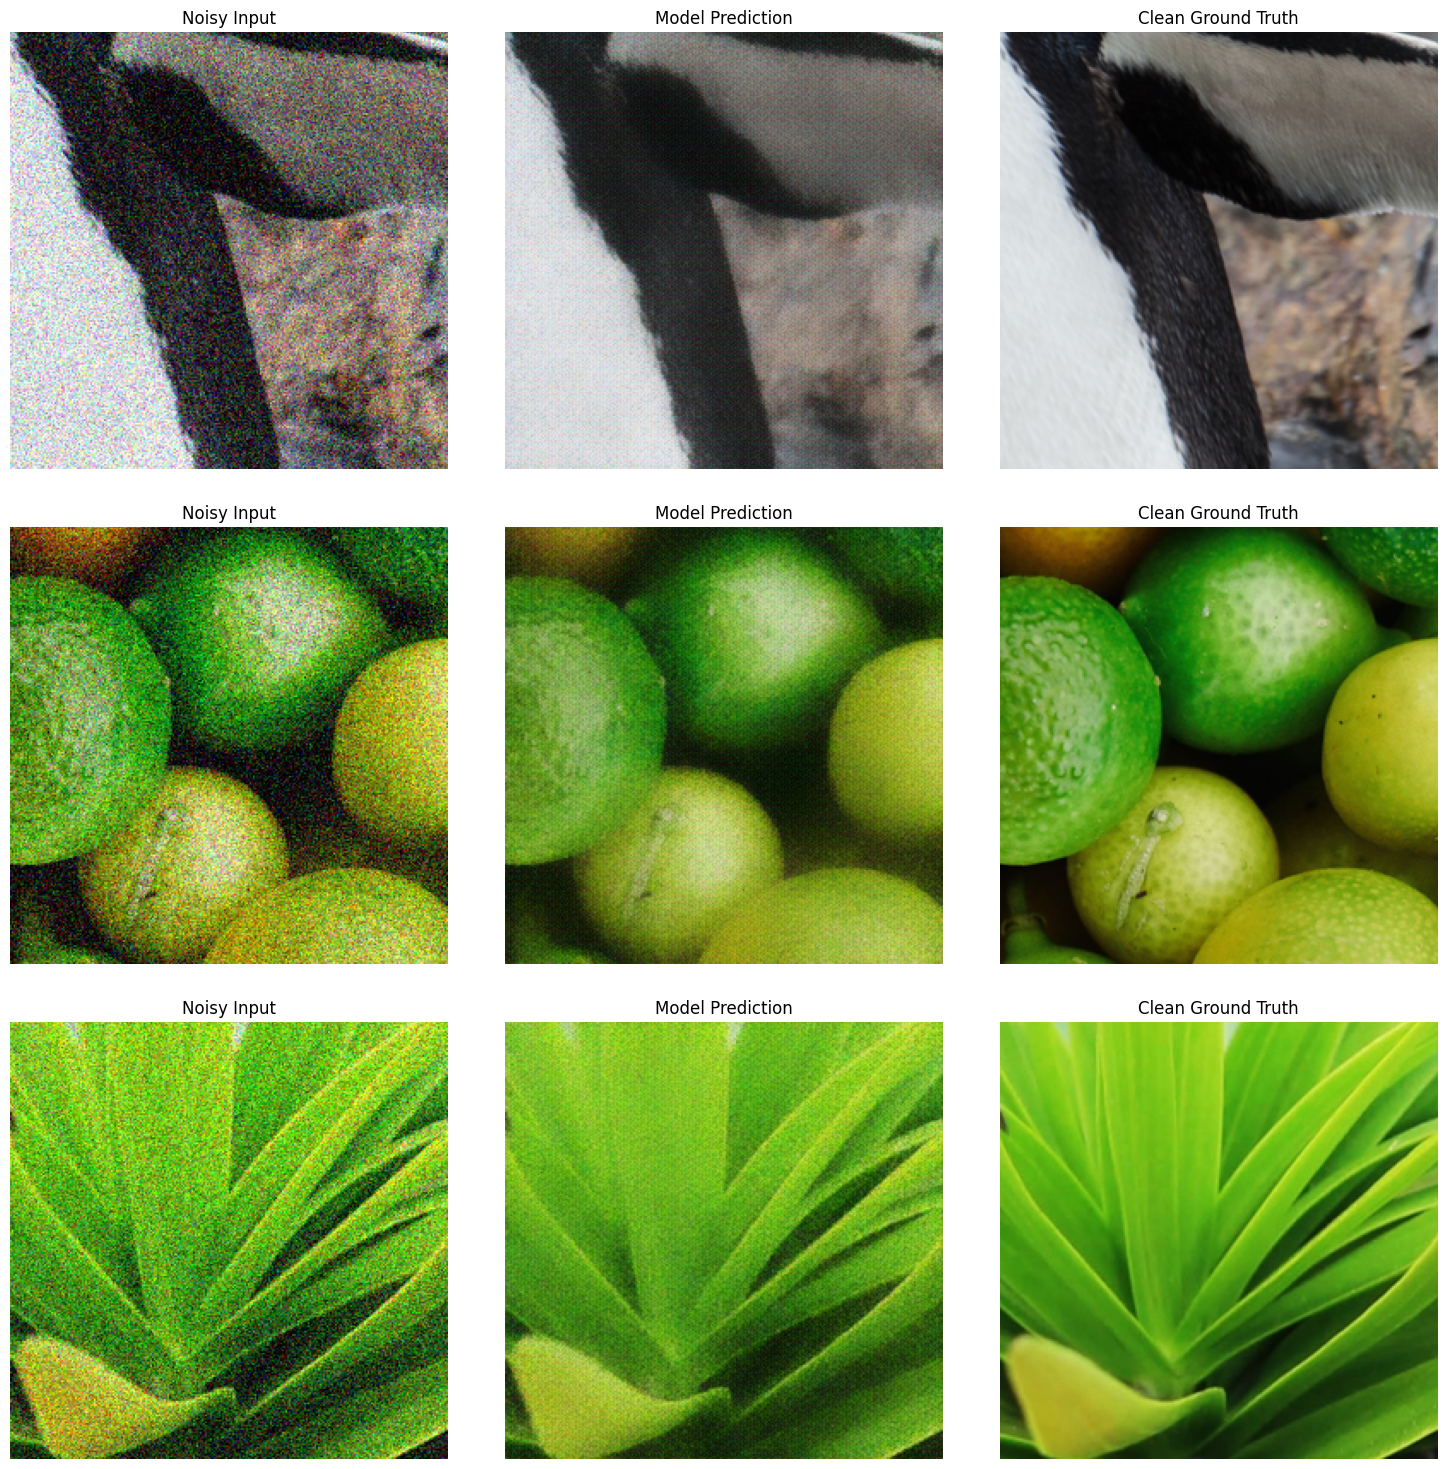

In [50]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def visualize_results(checkpoint_path, val_dir, num_samples=3):

    print(f"Loading model from {checkpoint_path}...")
    model = DenoisingModule.load_from_checkpoint(checkpoint_path)
    model.eval()
    model.freeze()

    dm = DenoisingDataModule(train_dir="", val_dir=val_dir, patch_size=256)
    dm.setup(stage=None)
    val_loader = dm.val_dataloader()

    batch = next(iter(val_loader))
    noisy_inputs, _, clean_targets = batch

    with torch.no_grad():
        denoised_outputs = model(noisy_inputs.to(model.device))

    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))
    plt.tight_layout()

    for i in range(num_samples):
        # [C, H, W] -> [H, W, C]
        noisy_img = noisy_inputs[i].permute(1, 2, 0).cpu().numpy()
        denoised_img = denoised_outputs[i].permute(1, 2, 0).cpu().numpy()
        clean_img = clean_targets[i].permute(1, 2, 0).cpu().numpy()

        denoised_img = np.clip(denoised_img, 0, 1)

        ax = axes[i] if num_samples > 1 else axes
        
        ax[0].imshow(noisy_img)
        ax[0].set_title("Noisy Input")
        ax[0].axis("off")

        ax[1].imshow(denoised_img)
        ax[1].set_title("Model Prediction")
        ax[1].axis("off")

        ax[2].imshow(clean_img)
        ax[2].set_title("Clean Ground Truth")
        ax[2].axis("off")

    plt.show()



CHECKPOINT = "checkpoints/best-checkpoint-epoch=46-val_psnr=24.10.ckpt" 
VAL_DIR = "../data/valid"

visualize_results(CHECKPOINT, VAL_DIR)